In [1]:
# Phase 1: Data Preprocessing for Twitter Airline Sentiment Analysis
# Person A - Social Media Computing Assignment

# Import libraries
import pandas as pd
import numpy as np
import os
import re
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Set random seed for reproducibility
np.random.seed(42)

In [2]:
# Create directory structure
os.makedirs('data', exist_ok=True)
os.makedirs('models/traditional_ml', exist_ok=True)
os.makedirs('models/deep_learning', exist_ok=True)
os.makedirs('models/transformers', exist_ok=True)
os.makedirs('dashboard', exist_ok=True)

print("Created directory structure")

Created directory structure


In [3]:
# Load dataset (assuming Tweets.csv is in data folder)
csv_path = 'data/Tweets.csv'
if not os.path.exists(csv_path):
    # Try current directory as backup
    csv_path = 'Tweets.csv'
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}")
        print("Please place Tweets.csv in the data/ folder or current directory")
    else:
        print("Found Tweets.csv in current directory")
        df = pd.read_csv(csv_path)
        print(f"Dataset loaded successfully!")
        print(f"Shape: {df.shape}")
else:
    df = pd.read_csv(csv_path)
    print(f"Dataset loaded from data/ folder successfully!")
    print(f"Shape: {df.shape}")

Dataset loaded from data/ folder successfully!
Shape: (14640, 15)


In [4]:
# Basic dataset information
print("\nDataset Info:")
print(df.info())



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null 

In [5]:
# Display first few rows
print("\nFirst 5 rows:")
df.head()


First 5 rows:


,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# Check unique values in sentiment column
print("\nSentiment distribution:")
print(df['airline_sentiment'].value_counts())


Sentiment distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


In [7]:
# Check for missing values in key columns
print("\nMissing values in key columns:")
print(df[['text', 'airline_sentiment', 'airline']].isnull().sum())


Missing values in key columns:
text                 0
airline_sentiment    0
airline              0
dtype: int64


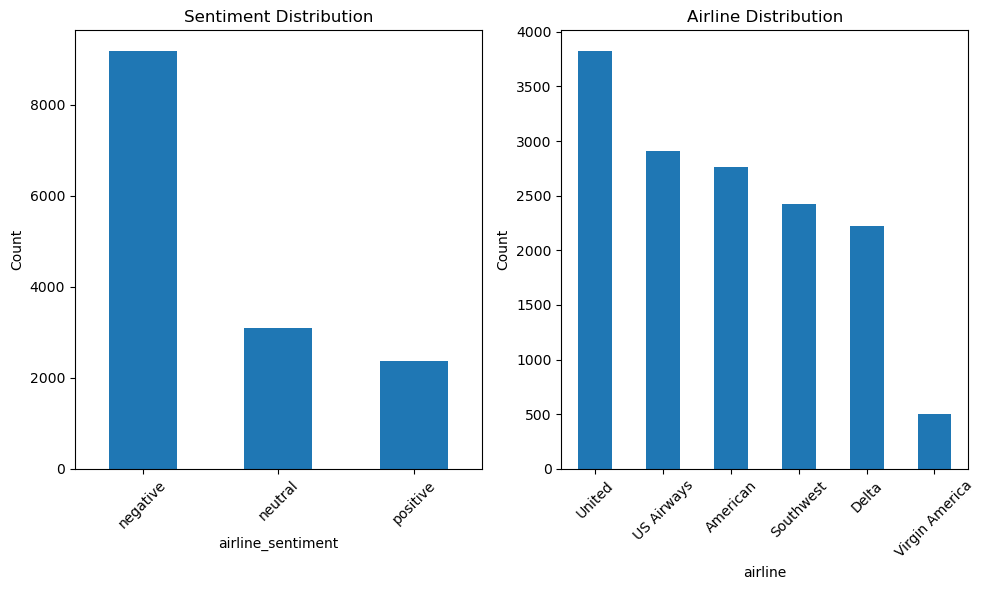

In [8]:
# Basic EDA - Sentiment distribution visualization
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df['airline_sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
df['airline'].value_counts().plot(kind='bar')
plt.title('Airline Distribution')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
# Text length analysis
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print("\nText statistics:")
print(f"Average text length: {df['text_length'].mean():.1f} characters")
print(f"Average word count: {df['word_count'].mean():.1f} words")
print(f"Max word count: {df['word_count'].max()}")


Text statistics:
Average text length: 103.8 characters
Average word count: 17.7 words
Max word count: 36


In [10]:
def preprocess_text(text):
    """Clean text for sentiment analysis"""
    if pd.isna(text):
        return ""

    # Lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove @mentions
    text = re.sub(r'@\w+', '', text)

    # Remove hashtag symbol but keep the word
    text = re.sub(r'#(\w+)', r'\1', text)

    # Regex-based tokenization (preserve contractions like "you've")
    words = re.findall(r"\b\w+'\w+|\w+\b", text)

    # Contraction and abbreviation dictionary
    contractions = {
        "don't": "do not", "won't": "will not", "can't": "cannot",
        "i'm": "i am", "you're": "you are", "he's": "he is", "she's": "she is",
        "it's": "it is", "we're": "we are", "they're": "they are",
        "i've": "i have", "you've": "you have", "we've": "we have", "they've": "they have",
        "i'd": "i would", "you'd": "you would", "he'd": "he would", "she'd": "she would",
        "we'd": "we would", "they'd": "they would",
        "i'll": "i will", "you'll": "you will", "he'll": "he will", "she'll": "she will",
        "we'll": "we will", "they'll": "they will",
        "didn't": "did not", "hasn't": "has not", "hadn't": "had not",
        "couldn't": "could not", "shouldn't": "should not", "wouldn't": "would not",
        "isn't": "is not", "aren't": "are not", "wasn't": "was not", "weren't": "were not",
        "n't": " not", "'re": " are", "'ve": " have", "'ll": " will",
        "'d": " would", "'m": " am",

        "u": "you", "ur": "your", "r": "are", "pls": "please", "plz": "please",
        "btw": "by the way", "idk": "i don't know", "imo": "in my opinion",
        "omg": "oh my god", "lol": "laugh out loud", "rofl": "rolling on the floor laughing",
        "lmao": "laughing my ass off", "smh": "shaking my head", "thx": "thanks",
        "ty": "thank you", "np": "no problem", "omw": "on my way", "b4": "before",
        "gr8": "great", "k": "okay", "bc": "because", "b/c": "because",
        "w/": "with", "w/o": "without", "bday": "birthday", "msg": "message",
        "fyi": "for your information", "asap": "as soon as possible", "brb": "be right back",
        "gtg": "got to go", "ttyl": "talk to you later", "afaik": "as far as i know",
        "icymi": "in case you missed it", "tbh": "to be honest", "im": "i am",
        "ive": "i have", "idc": "i don't care", "ikr": "i know right", "ya": "you",
        "ya'll": "you all", "sup": "what's up", "bff": "best friend forever",
        "bf": "boyfriend", "gf": "girlfriend"
    }

    # Replace contractions and abbreviations
    expanded_words = []
    for word in words:
        if word in contractions:
            expanded_words.extend(contractions[word].split())
        else:
            expanded_words.append(word)

    # Rejoin
    text = ' '.join(expanded_words)

    # Remove punctuation (but keep numbers)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Clean up spacing
    text = re.sub(r'\s+', ' ', text).strip()

    return text


In [11]:
# Apply text preprocessing
print("Applying text preprocessing...")
df['cleaned_text'] = df['text'].apply(preprocess_text)

Applying text preprocessing...


In [12]:
# Remove empty texts after cleaning
print(f"Texts before cleaning: {len(df)}")
df = df[df['cleaned_text'].str.len() > 0]
print(f"Texts after removing empty: {len(df)}")

Texts before cleaning: 14640
Texts after removing empty: 14640


In [13]:
# Create numeric labels
label_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}
df['label_numeric'] = df['airline_sentiment'].map(label_mapping)

print("\nLabel mapping:")
for original, numeric in label_mapping.items():
    count = df[df['airline_sentiment'] == original].shape[0]
    print(f"{original} -> {numeric}: {count} samples")


Label mapping:
positive -> 2: 2363 samples
neutral -> 1: 3099 samples
negative -> 0: 9178 samples


In [14]:
# Check cleaned text statistics
df['cleaned_length'] = df['cleaned_text'].str.len()
df['cleaned_word_count'] = df['cleaned_text'].str.split().str.len()

print("\nCleaned text statistics:")
print(f"Average cleaned text length: {df['cleaned_length'].mean():.1f} characters")
print(f"Average cleaned word count: {df['cleaned_word_count'].mean():.1f} words")
print(f"Max cleaned word count: {df['cleaned_word_count'].max()}")


Cleaned text statistics:
Average cleaned text length: 86.8 characters
Average cleaned word count: 16.8 words
Max cleaned word count: 34


In [15]:
# Show examples of before/after preprocessing
print("\nPreprocessing examples:")
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {df.iloc[i]['text']}")
    print(f"Cleaned:  {df.iloc[i]['cleaned_text']}")
    print(f"Sentiment: {df.iloc[i]['airline_sentiment']}")


Preprocessing examples:

Example 1:
Original: @VirginAmerica What @dhepburn said.
Cleaned:  what said
Sentiment: neutral

Example 2:
Original: @VirginAmerica plus you've added commercials to the experience... tacky.
Cleaned:  plus you have added commercials to the experience tacky
Sentiment: positive

Example 3:
Original: @VirginAmerica I didn't today... Must mean I need to take another trip!
Cleaned:  i did not today must mean i need to take another trip
Sentiment: neutral


In [16]:
# Create final cleaned dataset
cleaned_df = df[['tweet_id', 'text', 'cleaned_text', 'airline_sentiment', 'airline', 'label_numeric']].copy()
cleaned_df.rename(columns={'text': 'original_text'}, inplace=True)
cleaned_df['cleaned_word_count'] = cleaned_df['cleaned_text'].str.split().str.len()

print(f"\nFinal cleaned dataset shape: {cleaned_df.shape}")
print("\nFinal dataset columns:")
print(cleaned_df.columns.tolist())


Final cleaned dataset shape: (14640, 7)

Final dataset columns:
['tweet_id', 'original_text', 'cleaned_text', 'airline_sentiment', 'airline', 'label_numeric', 'cleaned_word_count']


In [17]:
# Save cleaned dataset
cleaned_df.to_csv('data/cleaned_data.csv', index=False)
print("Saved: data/cleaned_data.csv")

Saved: data/cleaned_data.csv


In [18]:
# Preprocessing configuration
PREPROCESSING_CONFIG = {
    # For TF-IDF
    'tfidf_max_features': 5000,
    'tfidf_ngram_range': (1, 2),
    'tfidf_min_df': 5,
    
    # For Deep Learning Tokenization
    'dl_max_features': 10000,
    'dl_max_length': 100,
    'test_size': 0.2,
    'random_state': 42
}

print("\nPreprocessing configuration:")
for key, value in PREPROCESSING_CONFIG.items():
    print(f"{key}: {value}")


Preprocessing configuration:
tfidf_max_features: 5000
tfidf_ngram_range: (1, 2)
tfidf_min_df: 5
dl_max_features: 10000
dl_max_length: 100
test_size: 0.2
random_state: 42


In [19]:
# Create train/test splits
X = cleaned_df['cleaned_text'].values
y = cleaned_df['label_numeric'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=PREPROCESSING_CONFIG['test_size'], 
    random_state=PREPROCESSING_CONFIG['random_state'],
    stratify=y
)

print(f"\nTrain/Test Split:")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Training label distribution: {np.bincount(y_train)}")
print(f"Testing label distribution: {np.bincount(y_test)}")


Train/Test Split:
Training samples: 11712
Testing samples: 2928
Training label distribution: [7343 2479 1890]
Testing label distribution: [1835  620  473]


In [20]:
# Save train/test splits
train_df = pd.DataFrame({'cleaned_text': X_train})
test_df = pd.DataFrame({'cleaned_text': X_test})
train_labels = pd.DataFrame({'label_numeric': y_train})
test_labels = pd.DataFrame({'label_numeric': y_test})

train_df.to_csv('data/X_train.csv', index=False)
test_df.to_csv('data/X_test.csv', index=False)
train_labels.to_csv('data/y_train.csv', index=False)
test_labels.to_csv('data/y_test.csv', index=False)

print("Saved: data/X_train.csv, data/X_test.csv, data/y_train.csv, data/y_test.csv")

Saved: data/X_train.csv, data/X_test.csv, data/y_train.csv, data/y_test.csv


In [21]:
# Create TF-IDF vectors for traditional ML
print("\nCreating TF-IDF vectors...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=PREPROCESSING_CONFIG['tfidf_max_features'],
    ngram_range=PREPROCESSING_CONFIG['tfidf_ngram_range'],
    min_df=PREPROCESSING_CONFIG['tfidf_min_df'],
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)



Creating TF-IDF vectors...


In [22]:
# Fit on training data and transform both train and test
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF training shape: {X_train_tfidf.shape}")
print(f"TF-IDF testing shape: {X_test_tfidf.shape}")
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

TF-IDF training shape: (11712, 3453)
TF-IDF testing shape: (2928, 3453)
TF-IDF vocabulary size: 3453


In [23]:
# Save TF-IDF vectors and vectorizer
with open('data/X_train_tfidf.pkl', 'wb') as f:
    pickle.dump(X_train_tfidf, f)
    
with open('data/X_test_tfidf.pkl', 'wb') as f:
    pickle.dump(X_test_tfidf, f)
    
with open('data/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

print("Saved: data/X_train_tfidf.pkl, data/X_test_tfidf.pkl, data/tfidf_vectorizer.pkl")

Saved: data/X_train_tfidf.pkl, data/X_test_tfidf.pkl, data/tfidf_vectorizer.pkl


In [24]:
# Create tokenized sequences for deep learning
print("\nCreating tokenized sequences for deep learning...")
tokenizer = Tokenizer(
    num_words=PREPROCESSING_CONFIG['dl_max_features'],
    oov_token='<OOV>',
    lower=True
)


Creating tokenized sequences for deep learning...


In [25]:
# Fit tokenizer on training data
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to same length
X_train_pad = pad_sequences(
    X_train_seq, 
    maxlen=PREPROCESSING_CONFIG['dl_max_length'],
    padding='post',
    truncating='post'
)

X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=PREPROCESSING_CONFIG['dl_max_length'], 
    padding='post',
    truncating='post'
)

print(f"Tokenized training shape: {X_train_pad.shape}")
print(f"Tokenized testing shape: {X_test_pad.shape}")
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Tokenized training shape: (11712, 100)
Tokenized testing shape: (2928, 100)
Vocabulary size: 11666


In [26]:
# Analyze sequence lengths
train_seq_lengths = [len(seq) for seq in X_train_seq]
print(f"Average sequence length: {np.mean(train_seq_lengths):.1f}")
print(f"Max sequence length: {np.max(train_seq_lengths)}")
print(f"Sequences longer than {PREPROCESSING_CONFIG['dl_max_length']}: {np.sum(np.array(train_seq_lengths) > PREPROCESSING_CONFIG['dl_max_length'])}")


Average sequence length: 16.8
Max sequence length: 32
Sequences longer than 100: 0


In [27]:
# Prepare tokenized data dictionary
tokenized_data = {
    'X_train_seq': X_train_seq,
    'X_test_seq': X_test_seq,
    'X_train_pad': X_train_pad,
    'X_test_pad': X_test_pad,
    'max_length': PREPROCESSING_CONFIG['dl_max_length'],
    'vocab_size': len(tokenizer.word_index) + 1,  # +1 for padding token
    'word_to_index': tokenizer.word_index,
    'index_to_word': {v: k for k, v in tokenizer.word_index.items()}
}

In [28]:
# Save tokenized data
with open('data/tokenized_sequences.pkl', 'wb') as f:
    pickle.dump(tokenized_data, f)
    
with open('data/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

print("Saved: data/tokenized_sequences.pkl, data/tokenizer.pkl")

Saved: data/tokenized_sequences.pkl, data/tokenizer.pkl


In [29]:
# Create evaluation utility functions
def evaluate_model(y_true, y_pred, model_name):
    """Standard evaluation function for both persons to use"""
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
    
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'classification_report': classification_report(y_true, y_pred)
    }
    
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    
    return results

def plot_confusion_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'], title='Confusion Matrix'):
    """Standard confusion matrix plotting function"""
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm


In [30]:
# Save evaluation functions
with open('evaluation_utils.py', 'w') as f:
    f.write('''# Evaluation utilities for sentiment analysis models

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(y_true, y_pred, model_name):
    """Standard evaluation function for both persons to use"""
    accuracy = accuracy_score(y_true, y_pred)
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'precision': precision,
        'recall': recall,
        'classification_report': classification_report(y_true, y_pred)
    }
    
    print(f"\\n{model_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score (weighted): {f1_weighted:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    
    return results

def plot_confusion_matrix(y_true, y_pred, labels=['Negative', 'Neutral', 'Positive'], title='Confusion Matrix'):
    """Standard confusion matrix plotting function"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    return cm
''')

print("Saved: evaluation_utils.py")

Saved: evaluation_utils.py


In [31]:
# Quality checks
print("\n" + "="*50)
print("QUALITY CHECKS")
print("="*50)

# Check no empty texts
empty_texts = (cleaned_df['cleaned_text'].str.len() == 0).sum()
print(f"Empty texts after cleaning: {empty_texts}")

# Check class distribution preserved
print(f"\nClass distribution in final dataset:")
print(cleaned_df['label_numeric'].value_counts().sort_index())

# Check train/test have same distribution
from scipy.stats import chi2_contingency
train_dist = np.bincount(y_train, minlength=3)
test_dist = np.bincount(y_test, minlength=3)
chi2, p_value = chi2_contingency([train_dist, test_dist])[:2]
print(f"\nTrain/test distribution similarity (p-value): {p_value:.4f}")
if p_value > 0.05:
    print("✓ Train and test distributions are similar")
else:
    print("⚠ Train and test distributions might be different")

# Check vocabulary size
print(f"\nVocabulary statistics:")
print(f"TF-IDF vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
print(f"Deep learning vocabulary size: {len(tokenizer.word_index)}")

# Check average sequence length vs max_length
avg_seq_len = np.mean([len(seq) for seq in X_train_seq])
print(f"\nSequence length analysis:")
print(f"Average sequence length: {avg_seq_len:.1f}")
print(f"Max length setting: {PREPROCESSING_CONFIG['dl_max_length']}")
if avg_seq_len < PREPROCESSING_CONFIG['dl_max_length'] * 0.8:
    print("✓ Max length setting is appropriate")

print("\n" + "="*50)
print("PREPROCESSING COMPLETE!")
print("="*50)


QUALITY CHECKS
Empty texts after cleaning: 0

Class distribution in final dataset:
label_numeric
0    9178
1    3099
2    2363
Name: count, dtype: int64

Train/test distribution similarity (p-value): 0.9996
✓ Train and test distributions are similar

Vocabulary statistics:
TF-IDF vocabulary size: 3453
Deep learning vocabulary size: 11666

Sequence length analysis:
Average sequence length: 16.8
Max length setting: 100
✓ Max length setting is appropriate

PREPROCESSING COMPLETE!


In [32]:
# Summary of files created
files_created = [
    'data/cleaned_data.csv',
    'data/X_train.csv', 'data/X_test.csv', 'data/y_train.csv', 'data/y_test.csv',
    'data/X_train_tfidf.pkl', 'data/X_test_tfidf.pkl', 'data/tfidf_vectorizer.pkl',
    'data/tokenized_sequences.pkl', 'data/tokenizer.pkl',
    'evaluation_utils.py'
]

print(f"\nFiles created for Person B:")
for file in files_created:
    if os.path.exists(file):
        print(f"✓ {file}")
    else:
        print(f"✗ {file} - NOT FOUND!")

print(f"\nDataset summary:")
print(f"Total samples: {len(cleaned_df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Average words per tweet: {cleaned_df['cleaned_word_count'].mean():.1f}")
print(f"Sentiment distribution: Negative: {(y_train==0).sum() + (y_test==0).sum()}, Neutral: {(y_train==1).sum() + (y_test==1).sum()}, Positive: {(y_train==2).sum() + (y_test==2).sum()}")

print("\n🎉 Ready for Person B to start working!")


Files created for Person B:
✓ data/cleaned_data.csv
✓ data/X_train.csv
✓ data/X_test.csv
✓ data/y_train.csv
✓ data/y_test.csv
✓ data/X_train_tfidf.pkl
✓ data/X_test_tfidf.pkl
✓ data/tfidf_vectorizer.pkl
✓ data/tokenized_sequences.pkl
✓ data/tokenizer.pkl
✓ evaluation_utils.py

Dataset summary:
Total samples: 14640
Training samples: 11712
Testing samples: 2928
Average words per tweet: 16.8
Sentiment distribution: Negative: 9178, Neutral: 3099, Positive: 2363

🎉 Ready for Person B to start working!
